In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import genextreme
import pandas as pd

In [2]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super(LinearNetwork,self).__init__()
        self.fc1=nn.Linear(2,10)
        self.fc2=nn.Linear(10,1)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model=LinearNetwork()

In [3]:
def training_set_output(dataset):
    maximum_ = dataset['TOT_PR'].values
    output = torch.tensor(maximum_, dtype=torch.float32)
    output=output.permute(1, 2, 0)
    return output

In [4]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

In [5]:
gev_params=pd.read_csv('gev_data.csv')
gev_params

,rlon,rlat,shape,scale,loc
0,-2.4,-0.50,-0.052415,0.006250,0.009024
1,-2.4,-0.48,0.327008,0.000238,0.000770
2,-2.4,-0.46,0.673582,0.000637,0.002159
3,-2.4,-0.44,0.889250,0.001780,0.002357
4,-2.4,-0.42,0.117413,0.002109,0.004631
...,...,...,...,...,...
60,-2.3,-0.38,0.407793,0.001053,0.003004
61,-2.3,-0.36,0.239843,0.001181,0.004598
62,-2.3,-0.34,-0.095603,0.002203,0.004893
63,-2.3,-0.32,0.105636,0.001089,0.003303


In [6]:
gev_params
selected_cols = gev_params[['rlon', 'rlat']]

gev_tensor = torch.tensor(selected_cols.values)


In [7]:
model.double()

LinearNetwork(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)

In [8]:
lat_bnd = [-0.5,-0.3]
lon_bnd = [-2.4,-2.3]

In [9]:
os.chdir("/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data")
summer_monthly=pd.read_csv('summer_monthly.csv')
train_data=xr.open_dataset('train_data_stationnary.nc')
num_weeks = len(train_data['week'])
print("Nombre de semaines :", num_weeks)
train_data=train_data.sel(rlon=slice(*lon_bnd), rlat=slice(*lat_bnd))

Nombre de semaines : 312


In [10]:
train_data

<xarray.Dataset>
Dimensions:  (week: 312, rlat: 11, rlon: 6)
Coordinates:
  * week     (week) int32 12 27 50 20 20 24 48 51 45 ... 5 25 12 10 30 48 52 11
    year     (week) int32 ...
  * rlon     (rlon) float32 -2.4 -2.38 -2.36 -2.34 -2.32 -2.3
  * rlat     (rlat) float32 -0.5 -0.48 -0.46 -0.44 ... -0.36 -0.34 -0.32 -0.3
Data variables:
    TOT_PR   (week, rlat, rlon) float32 ...

In [11]:
batch_output = training_set_output(train_data)
batch_output = torch.reshape(batch_output, (batch_output.size(0) * batch_output.size(1), batch_output.size(2)))

In [14]:
summer_monthly
grouped_df = summer_monthly.groupby(['rlon', 'rlat'])['TOT_PR'].apply(list).reset_index()
grouped_df

,rlon,rlat,TOT_PR
0,-2.5,-0.48,"[0.0020235016, 0.0017088003, 0.0019930052, 0.0..."
1,-2.5,-0.46,"[0.0014999581, 0.00084734027, 0.0059052296, 0...."
2,-2.5,-0.44,"[0.0014079234, 0.0010501385, 0.009857428, 0.00..."
3,-2.5,-0.42,"[0.0026193191, 0.0009269053, 0.008701576, 0.00..."
4,-2.5,-0.40,"[0.0021098787, 0.0006925797, 0.0027664807, 0.0..."
...,...,...,...
1075,-1.8,0.02,"[0.0016891523, 0.0038471972, 0.0063910815, 0.0..."
1076,-1.8,0.04,"[0.0017889219, 0.002176622, 0.0083676055, 0.00..."
1077,-1.8,0.06,"[0.0039983876, 0.0010964547, 0.006053826, 0.00..."
1078,-1.8,0.08,"[0.003981921, 0.0010431134, 0.002440064, 0.004..."


In [27]:
num_epoch=50
nb_lon= len(train_data['rlon'])
nb_lat= len(train_data['rlat'])
input=gev_tensor
optimizer1= torch.optim.Adam(model.parameters(), lr=0.1)

Epoch [10/50], Loss_LNN1: 0.0043
Epoch [20/50], Loss_LNN1: 0.0317
Epoch [30/50], Loss_LNN1: 0.0338
Epoch [40/50], Loss_LNN1: 0.0031


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch [50/50], Loss_LNN1: 0.0125


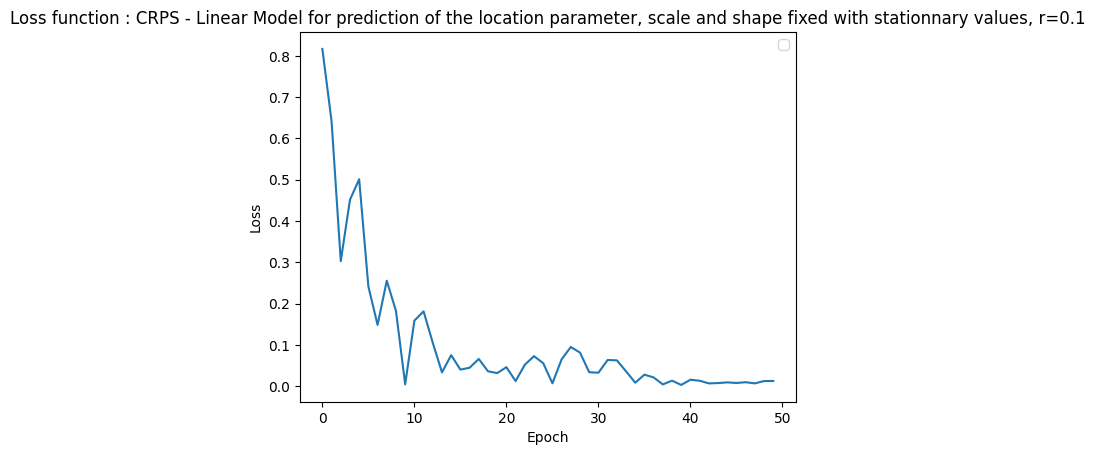

In [28]:
loss_crps=CustomCRPSLoss()
loss_list1=[]

for epoch in range(num_epoch):
        #print('EPOCH : ',epoch)
        #print(list(model.parameters()))
        outputs_lnn=model(input)
        #outputs_ann=model2(input)
        #print(outputs[1,1,1])

        loc = outputs_lnn[:,0]
        #print(loc.size())
        size = (nb_lon*nb_lat,batch_output.shape[1])
        u = torch.rand(size)

        loc=loc.unsqueeze(-1).repeat(1, 1, size[1])
        loc = torch.transpose(loc, 0, 1)

        ##On fixe xi et scale
        c=torch.tensor(gev_params['shape'])
        scale=torch.tensor(gev_params['scale'])
        c=c.unsqueeze(-1).repeat(1, 1, size[1])
        c = torch.transpose(c, 0, 1)
        #print(c)
        scale=scale.unsqueeze(-1).repeat(1, 1, size[1])
        scale = torch.transpose(scale, 0, 1)
    
        
        sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
        #print('sample',sample)
       
        #print('sample',sample.size())
        #print('batch_output',batch_output.size())
        loss1=loss_crps(sample,batch_output)
        loss_list1.append(torch.detach(loss1).numpy())
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        
    
    
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list1)
plt.title('Loss function : CRPS - Linear Model for prediction of the location parameter, scale and shape fixed with stationnary values, r=0.1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
#plt.plot(loss_list2)
plt.show()

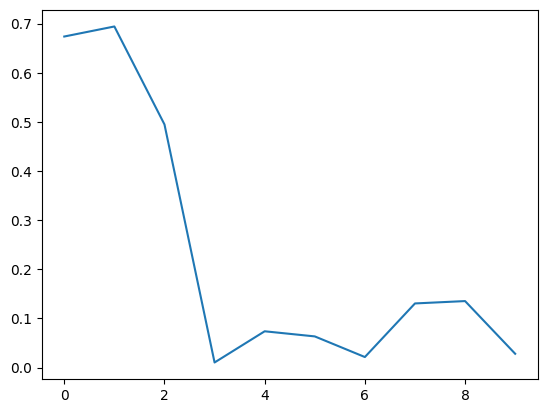

In [55]:
plt.plot(loss_list1)

In [118]:
input_test = torch.tensor([-2.35,-0.5],dtype=torch.double)
model(input_test)

tensor([0.0085], dtype=torch.float64, grad_fn=<AddBackward0>)

In [46]:
batch_output.size()

torch.Size([66, 312])

In [17]:
train_df=train_data.to_dataframe

In [105]:
class LinearNetworkTemp(nn.Module):
    def __init__(self):
        super(LinearNetworkTemp,self).__init__()
        self.fc1=nn.Linear(3,5)
        self.fc2=nn.Linear(5,1)
        custom_weights_fc1 = torch.tensor([[0.001, -0.002, 0.001],[0.001, -0.002, 0.001],[0.001, -0.002, 0.01],[0.001, -0.002, 0.01],[0.001, -0.002, 0.001]])
        self.fc1.weight.data = custom_weights_fc1

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model_temp=LinearNetworkTemp()
model_temp.double()

LinearNetworkTemp(
  (fc1): Linear(in_features=3, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
)

In [6]:
os.chdir("/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data")
#var_summer=pd.read_csv('data_variables.csv')
var_janv_fev=pd.read_csv('janvier_fevrier_variables_leman.csv')
var_mars_avril=pd.read_csv('mars_avril_variables_leman.csv')
var_ja=pd.read_csv('downscaling_values_ja.csv')

In [7]:
#selected_cols = var_summer[['rlon', 'rlat','temperature']]
#with_temp_summer = torch.tensor(selected_cols.values)
selected_cols = var_janv_fev[['rlon', 'rlat','temperature']]
with_temp_jf = torch.tensor(selected_cols.values)
selected_cols = var_mars_avril[['rlon', 'rlat','temperature']]
with_temp_ma = torch.tensor(selected_cols.values)
selected_cols = var_ja[['rlon', 'rlat','temperature']]

In [18]:
def train_set(input_tensor_list,precip_list,gev_params):
    res=[]
    for i in range(len(input_tensor_list)):
        c = torch.tensor(gev_params[i]['shape'])
        c = c.reshape(60, 60)
        c = torch.transpose(c, 0,1) ##oujours 60,60
        c = c.repeat(22,1,1)
        c = torch.permute(c,(1,2,0))
        scale = torch.tensor(gev_params[i]['scale'])
        scale = scale.reshape(60, 60)
        scale = torch.transpose(scale, 0, 1)  # Toujours 60, 60
        scale = scale.repeat(22, 1, 1)
        scale = torch.permute(scale, (1, 2, 0))

        precip = torch.flatten(precip_list[i],end_dim=1)
        precip = precip.permute(1,2,0)
        lst=[input_tensor_list[i],precip,scale,c]
        res.append(lst)
    return res

input_tensor_list = [with_temp_jf,with_temp_ma]

path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/utils"
os.chdir(path)
import dataset_for_R
out_janv_fev = dataset_for_R.get_precipitation_xarray('janvier','fevrier',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))
out_mars_avril = dataset_for_R.get_precipitation_xarray('mars','avril',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))

out_jf = torch.tensor(out_janv_fev.values)
out_ma = torch.tensor(out_mars_avril.values)

precip_list = [out_jf, out_ma]

gev_params_jf=pd.read_csv('gev_data_janv_fev.csv')
gev_params_ma=pd.read_csv('gev_data_mars_avril.csv')

gev_params = [gev_params_jf,gev_params_ma]

NameError: name 'with_temp_jf' is not defined

In [9]:
num_epoch=100
model_temp=LinearNetworkTemp()
model_temp.double()
optimizer1= torch.optim.Adam(model_temp.parameters(), lr=0.1)

Epoch [10/100], Loss_LNN1: 13.2728
Epoch [20/100], Loss_LNN1: 2.9325
Epoch [30/100], Loss_LNN1: 0.5151
Epoch [40/100], Loss_LNN1: 0.5153
Epoch [50/100], Loss_LNN1: 0.4010
Epoch [60/100], Loss_LNN1: 0.0824
Epoch [70/100], Loss_LNN1: 0.0315
Epoch [80/100], Loss_LNN1: 0.0056
Epoch [90/100], Loss_LNN1: 0.0046
Epoch [100/100], Loss_LNN1: 0.0041


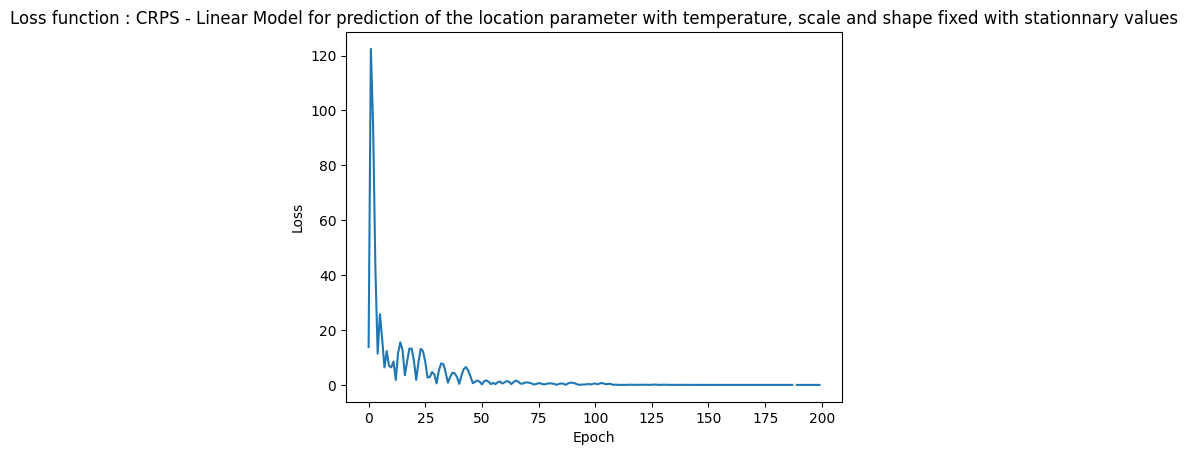

In [146]:
loss_crps=CustomCRPSLoss()
loss_list_temp=[]
training_set = train_set(input_tensor_list,precip_list,gev_params)
for epoch in range(num_epoch):
        for elem in training_set :
            input_temp = elem[0]            
            batch_output = elem[1]
            c =  elem[3]
            scale = elem[2]
            
            outputs_lnn=model_temp(input_temp)
            loc = outputs_lnn[:,0]
            loc = loc.reshape(60, 60)
            loc = torch.transpose(loc, 0,1) ##oujours 60,60
            loc = loc.repeat(22,1,1)
            loc = torch.permute(loc, (1, 2, 0))

            size = (batch_output.shape[0],batch_output.shape[1],batch_output.shape[2])
            u = torch.rand(size)
    
            sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
            
            loss1 = loss_crps(sample,batch_output)
            
            loss_list_temp.append(torch.detach(loss1).numpy())
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
       
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list_temp)
plt.title('Loss function : CRPS - Linear Model for prediction of the location parameter with temperature, scale and shape fixed with stationnary values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_list2)
plt.show()

In [147]:
input_test = torch.tensor([ -2.6000,  -0.4000, 290.9261],dtype=torch.double)
model_temp(input_test)

tensor([0.0073], dtype=torch.float64, grad_fn=<AddBackward0>)

In [110]:
class LinearNetworkTempHum(nn.Module):
    def __init__(self):
        super(LinearNetworkTempHum,self).__init__()
        self.fc1=nn.Linear(4,4)
        self.fc2=nn.Linear(4,1)

        custom_weights_fc1 = torch.tensor([[0.001, -0.002, 0.001, 0.001],[0.001, -0.002, 0.001, 0.001],[0.001, -0.002, 0.01, 0.001],[0.001, -0.002, 0.01, 0.001]])
        self.fc1.weight.data = custom_weights_fc1

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        x = torch.abs(x)
        return x

model_temp_hum=LinearNetworkTempHum()
model_temp_hum.double()

LinearNetworkTempHum(
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=1, bias=True)
)

In [74]:
selected_cols = var_janv_fev[['rlon', 'rlat','temperature','humidity']]
with_more_jf = torch.tensor(selected_cols.values)
selected_cols = var_mars_avril[['rlon', 'rlat','temperature','humidity']]
with_more_ma = torch.tensor(selected_cols.values)
with_temp_jf

NameError: name 'var_janv_fev' is not defined

In [12]:
num_epoch = 100
optimizer1 = torch.optim.Adam(model_temp_hum.parameters(), lr=0.1)
input_tensor_list = [with_more_jf,with_more_ma]

Epoch [10/100], Loss_LNN1: 12.4855
Epoch [20/100], Loss_LNN1: 0.2086
Epoch [30/100], Loss_LNN1: 0.4023
Epoch [40/100], Loss_LNN1: 0.1517
Epoch [50/100], Loss_LNN1: 0.1263
Epoch [60/100], Loss_LNN1: 0.0548
Epoch [70/100], Loss_LNN1: 0.0410
Epoch [80/100], Loss_LNN1: 0.0387
Epoch [90/100], Loss_LNN1: 0.0315
Epoch [100/100], Loss_LNN1: 0.0461


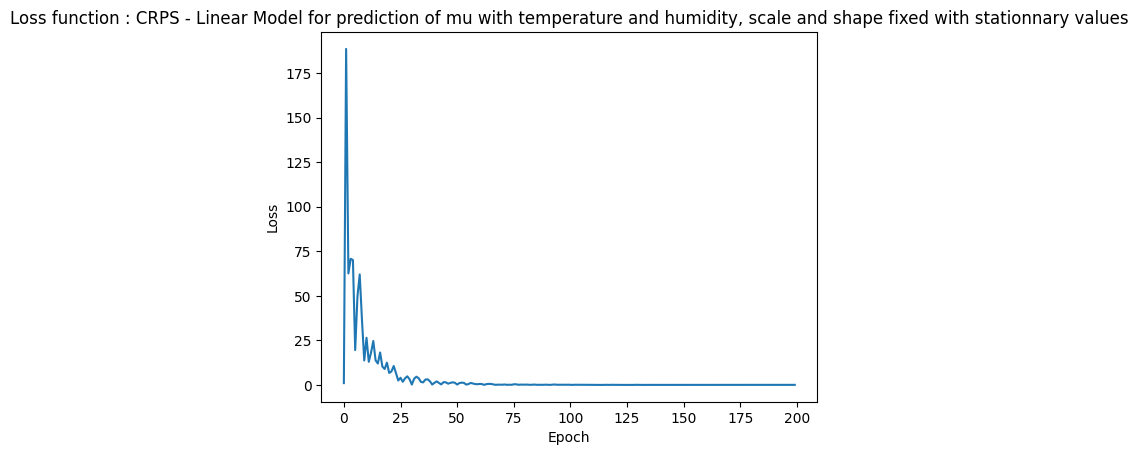

In [206]:
loss_crps=CustomCRPSLoss()
loss_list_temp_hum=[]
training_set = train_set(input_tensor_list,precip_list,gev_params)
for epoch in range(num_epoch):
        for elem in training_set :
            input = elem[0]            
            batch_output = elem[1]
            c =  elem[3]
            scale = elem[2]
            
            outputs_lnn=model_temp_hum(input)
            loc = outputs_lnn[:,0]
            loc = loc.reshape(60, 60)
            loc = torch.transpose(loc, 0,1) ##oujours 60,60
            loc = loc.repeat(22,1,1)
            loc = torch.permute(loc, (1, 2, 0))

            size = (batch_output.shape[0],batch_output.shape[1],batch_output.shape[2])
            u = torch.rand(size)
    
            sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
            
            loss1 = loss_crps(sample,batch_output)
            
            loss_list_temp_hum.append(torch.detach(loss1).numpy())
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
       
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list_temp_hum)
plt.title('Loss function : CRPS - Linear Model for prediction of mu with temperature and humidity, scale and shape fixed with stationnary values')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_list2)
plt.show()

In [208]:
input_test = torch.tensor([ -2.4000,  0.5000, 280.9261,90.0734],dtype=torch.double)
model_temp_hum(input_test)

tensor([0.0126], dtype=torch.float64, grad_fn=<AddBackward0>)

In [11]:
class LinearNetworkDown(nn.Module):
    def __init__(self):
        super(LinearNetworkDown,self).__init__()
        self.fc1=nn.Linear(5,20)
        self.fc2=nn.Linear(20,1)

    def forward(self,x):
        x=self.fc1(x)
        x=self.fc2(x)
        return x

model_ds=LinearNetworkDown()
model_ds.double()

LinearNetworkDown(
  (fc1): Linear(in_features=5, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)

In [12]:
var_ja=pd.read_csv('downscaling_values_ja.csv') #ja for july_august
selected_cols = var_ja[['rlon', 'rlat','temperature','humidity','mu']]
with_more_ja = torch.tensor(selected_cols.values)

In [13]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/utils"
os.chdir(path)
import dataset_for_R
out_ja = dataset_for_R.get_precipitation_xarray('juillet','aout',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))

out_ja = torch.tensor(out_ja.values)
precip_list = [out_ja]

gev_params_ja=pd.read_csv('gev_data_juillet_aout.csv')
gev_params = [gev_params_ja]

input_tensor_list = [with_more_ja]

num_epoch = 200
optimizer1 = torch.optim.Adam(model_ds.parameters(), lr=0.1)

Epoch [10/200], Loss_LNN1: 22.8318
Epoch [20/200], Loss_LNN1: 7.7144
Epoch [30/200], Loss_LNN1: 1.0531
Epoch [40/200], Loss_LNN1: 1.8304
Epoch [50/200], Loss_LNN1: 2.4222
Epoch [60/200], Loss_LNN1: 0.5188
Epoch [70/200], Loss_LNN1: 0.2877
Epoch [80/200], Loss_LNN1: 0.3251
Epoch [90/200], Loss_LNN1: 0.1138
Epoch [100/200], Loss_LNN1: 0.0353
Epoch [110/200], Loss_LNN1: 0.0202
Epoch [120/200], Loss_LNN1: 0.0118
Epoch [130/200], Loss_LNN1: 0.0091
Epoch [140/200], Loss_LNN1: 0.0073
Epoch [150/200], Loss_LNN1: 0.0036
Epoch [160/200], Loss_LNN1: 0.0033
Epoch [170/200], Loss_LNN1: 0.0037
Epoch [180/200], Loss_LNN1: 0.0033
Epoch [190/200], Loss_LNN1: 0.0037
Epoch [200/200], Loss_LNN1: 0.0038


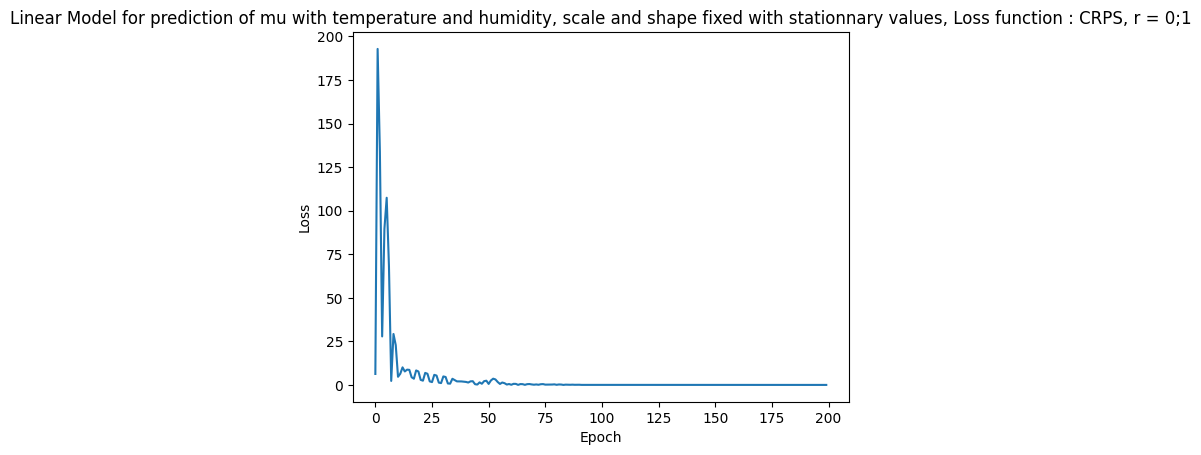

In [16]:
loss_crps=CustomCRPSLoss()
loss_list_temp_hum=[]
training_set = train_set(input_tensor_list,precip_list,gev_params)
for epoch in range(num_epoch):
        for elem in training_set :
            input = elem[0]       
            batch_output = elem[1]
            c =  elem[3]
            scale = elem[2]
            
            outputs_lnn=model_ds(input)
            loc = outputs_lnn[:,0]
            loc = loc.reshape(60, 60)
            loc = torch.transpose(loc, 0,1) ##oujours 60,60
            loc = loc.repeat(22,1,1)
            loc = torch.permute(loc, (1, 2, 0))

            size = (batch_output.shape[0],batch_output.shape[1],batch_output.shape[2])
            u = torch.rand(size)
    
            sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
            
            loss1 = loss_crps(sample,batch_output)
            
            loss_list_temp_hum.append(torch.detach(loss1).numpy())
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
       
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list_temp_hum)
plt.title('Linear Model for prediction of mu with temperature and humidity, scale and shape fixed with stationnary values, Loss function : CRPS, r = 0;1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_list2)
plt.show()

In [49]:
input_test = with_more_ja[10:20]
input_test
print('Model results :', model_ds(input_test))
print('Truth :', gev_params_ja[10:20]['loc'])

Model results : tensor([[0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0041],
        [0.0042]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
Truth : 10    0.005854
11    0.003594
12    0.005287
13    0.004348
14    0.006250
15    0.004645
16    0.006646
17    0.005495
18    0.004825
19    0.005048
Name: loc, dtype: float64


In [ ]:
##AVEC SCALE ET SHAPE QUI SONT LES MEMES CONSTANTES QUE LE MODELE STAT: 

Epoch [10/150], Loss_LNN1: 92.5723
Epoch [20/150], Loss_LNN1: 14.7784
Epoch [30/150], Loss_LNN1: 9.6271
Epoch [40/150], Loss_LNN1: 7.8332
Epoch [50/150], Loss_LNN1: 1.6435
Epoch [60/150], Loss_LNN1: 1.1224
Epoch [70/150], Loss_LNN1: 0.2640
Epoch [80/150], Loss_LNN1: 0.6518
Epoch [90/150], Loss_LNN1: 0.2902
Epoch [100/150], Loss_LNN1: 0.1055
Epoch [110/150], Loss_LNN1: 0.0238
Epoch [120/150], Loss_LNN1: 0.0192
Epoch [130/150], Loss_LNN1: 0.0069
Epoch [140/150], Loss_LNN1: 0.0039
Epoch [150/150], Loss_LNN1: 0.0041


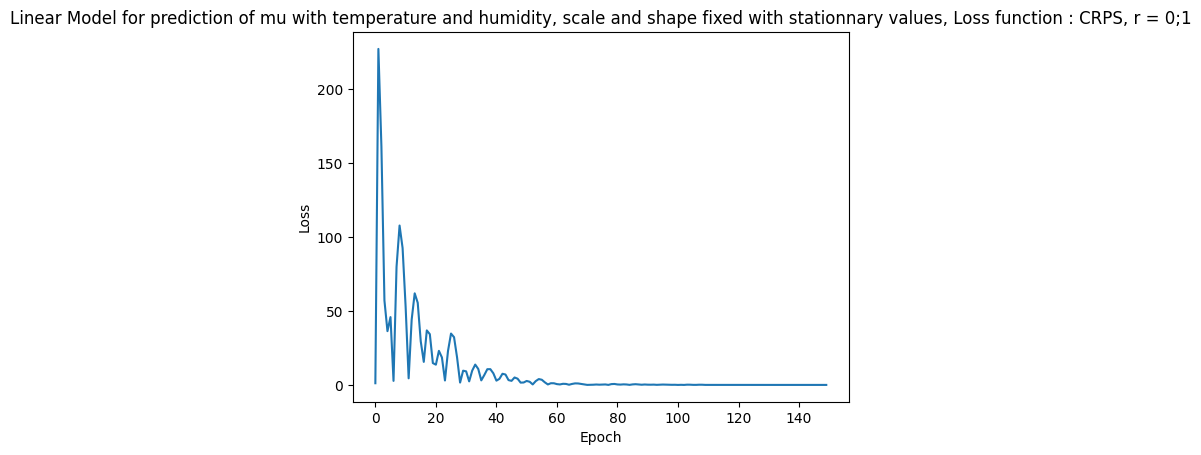

In [53]:
loss_crps=CustomCRPSLoss()
loss_list_temp_hum=[]
training_set = train_set(input_tensor_list,precip_list,gev_params)
for epoch in range(num_epoch):
        for elem in training_set :
            input = elem[0]       
            batch_output = elem[1]
            c = 0.2120344
            scale = 0.003193901
            
            outputs_lnn=model_ds(input)
            loc = outputs_lnn[:,0]
            loc = loc.reshape(60, 60)
            loc = torch.transpose(loc, 0,1) ##oujours 60,60
            loc = loc.repeat(22,1,1)
            loc = torch.permute(loc, (1, 2, 0))

            size = (batch_output.shape[0],batch_output.shape[1],batch_output.shape[2])
            u = torch.rand(size)
    
            sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
            
            loss1 = loss_crps(sample,batch_output)
            
            loss_list_temp_hum.append(torch.detach(loss1).numpy())
            optimizer1.zero_grad()
            loss1.backward()
            optimizer1.step()
       
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss1.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')
plt.plot(loss_list_temp_hum)
plt.title('Linear Model for prediction of mu with temperature and humidity, scale and shape fixed with stationnary values, Loss function : CRPS, r = 0;1')
plt.xlabel('Epoch')
plt.ylabel('Loss')
#plt.plot(loss_list2)
plt.show()

In [54]:
input_test = with_more_ja[10:20]
input_test
print('Model results :', model_ds(input_test))
print('Truth :', gev_params_ja[10:20]['loc'])

Model results : tensor([[-5.8147e-05],
        [-4.7217e-05],
        [-3.6288e-05],
        [-2.5358e-05],
        [-1.4428e-05],
        [-3.4986e-06],
        [-4.9375e-05],
        [-3.8445e-05],
        [-2.7516e-05],
        [-1.6586e-05]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
Truth : 10    0.005854
11    0.003594
12    0.005287
13    0.004348
14    0.006250
15    0.004645
16    0.006646
17    0.005495
18    0.004825
19    0.005048
Name: loc, dtype: float64


In [142]:
##Dataset : the closest neighboord taken into account 
os.chdir("/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data")

dataset_ja = pd.read_csv('downscaling_values_ja.csv')
dataset_mj = pd.read_csv('downscaling_values_mj.csv')
dataset_so = pd.read_csv('downscaling_values_so.csv')

In [20]:
##Il faut entrainer les 4 modèles

In [144]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/utils"
os.chdir(path)
import dataset_for_R
out_ja = dataset_for_R.get_precipitation_xarray('juillet','aout',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))
out_ja = torch.tensor(out_ja.values)
out_mj = dataset_for_R.get_precipitation_xarray('mai','juin',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))
out_mj = torch.tensor(out_mj.values)
out_so = dataset_for_R.get_precipitation_xarray('septembre','octobre',lon_bnd=(-2.6, -1.42),lat_bnd=(-0.6, 0.58))
out_so = torch.tensor(out_so.values)
precip_list = [out_mj,out_ja,out_so]


gev_params_ja=pd.read_csv('gev_data_juillet_aout.csv')
gev_params_mj=pd.read_csv('gev_data_mai_juin.csv')
gev_params_so = pd.read_csv('gev_data_septembre_octobre.csv')
gev_params = [gev_params_mj,gev_params_ja,gev_params_so]


selected_cols = dataset_ja[['rlon', 'rlat','temperature','humidity']]
dataset_ja = torch.tensor(selected_cols.values)
selected_cols = dataset_mj[['rlon', 'rlat','temperature','humidity']]
dataset_mj = torch.tensor(selected_cols.values)
selected_cols = dataset_so[['rlon', 'rlat','temperature','humidity']]
dataset_so = torch.tensor(selected_cols.values)

input_tensor_list = [dataset_mj,dataset_ja,dataset_so]

In [145]:
num_epoch = 300
loss_crps=CustomCRPSLoss()
loss_list_basic =[]
loss_list_temp = []
loss_list_hum = []

model_basic = LinearNetwork()
model_temp = LinearNetworkTemp()
model_temphum = LinearNetworkTempHum()

model_basic.double()
model_temp.double()
model_temphum.double()

optimizer1 = torch.optim.Adam(model_basic.parameters(), lr=0.001)
optimizer2 = torch.optim.Adam(model_temp.parameters(), lr=0.0001)
optimizer3 = torch.optim.Adam(model_temphum.parameters(), lr=0.0001)

training_set = train_set(input_tensor_list,precip_list,gev_params)

In [146]:
for epoch in range(num_epoch):
        for elem in training_set :
            batch_output = elem[1]
            c =  elem[3]
            scale = elem[2]
            for i in range(1,4):
                if (i==1): ##Modèle basic
                    input = elem[0][:, :2]
                    outputs_lnn=model_basic(input)
                if (i==2) : ##With temperature
                    input = elem[0][:, :3]
                    outputs_lnn=model_temp(input)
                if (i==3) : ##With temperature
                    input = elem[0][:, :4]
                    outputs_lnn=model_temphum(input)
                    
            
                loc = outputs_lnn[:,0]
                loc = loc.reshape(60, 60)
                loc = torch.transpose(loc, 0,1) ##oujours 60,60
                loc = loc.repeat(22,1,1)
                loc = torch.permute(loc, (1, 2, 0))
    
                size = (batch_output.shape[0],batch_output.shape[1],batch_output.shape[2])
                u = torch.rand(size)
        
                sample = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c


                loss = loss_crps(sample,batch_output)
                
                if (i==1): ##Modèle basic
                    loss_list_basic.append(torch.detach(loss).numpy())
                    optimizer1.zero_grad()
                    loss.backward()
                    optimizer1.step()
                if (i==2) : ##With temperature
                    loss_list_temp.append(torch.detach(loss).numpy())
                    optimizer2.zero_grad()
                    loss.backward()
                    optimizer2.step()
                if (i==3) : ##With temperature
                    loss_list_hum.append(torch.detach(loss).numpy())
                    optimizer3.zero_grad()
                    loss.backward()
                    optimizer3.step()       
                
                

        if (epoch+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN1: {loss.item():.4f}')
            #print(f'Epoch [{epoch+1}/{num_epoch}], Loss_LNN2: {loss2.item():.4f}')

Epoch [100/300], Loss_LNN1: 0.0026
Epoch [200/300], Loss_LNN1: 0.0059
Epoch [300/300], Loss_LNN1: 0.0063


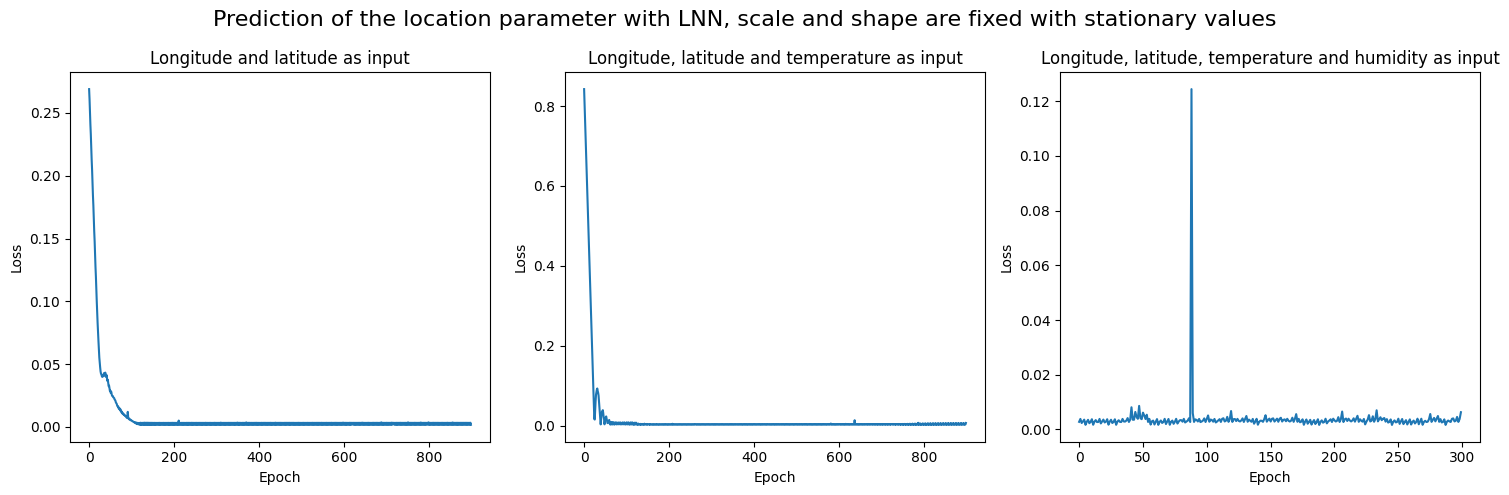

In [160]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                            
# Tracer le premier graphe dans la première colonne
axs[0].plot(loss_list_basic)
axs[0].set_title('Longitude and latitude as input')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')

# Tracer le deuxième graphe dans la deuxième colonne
axs[1].plot(loss_list_temp)
axs[1].set_title('Longitude, latitude and temperature as input')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')

# Tracer le troisième graphe dans la troisième colonne
axs[2].plot(loss_list_hum)
axs[2].set_title('Longitude, latitude, temperature and humidity as input')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Loss')

# Titre commun pour les 3 graphes
plt.suptitle('Prediction of the location parameter with LNN, scale and shape are fixed with stationary values', fontsize=16)

# Afficher tous les graphes
plt.tight_layout()
plt.show()


In [159]:
print('CRPS loss at the end for model 1 :',loss_list_basic[-1])
print('CRPS loss at the end for model 2 :',loss_list_temp[-1])
print('CRPS loss at the end for model 3 :',loss_list_hum[-1])
input_test = dataset_ja[10:20]

print('Prediction example model 1 :', model_basic(input_test[:,:2]))
print('Prediction example model 2 :', model_temp(input_test[:,:3]))
print('Prediction example model 3 :', model_temphum(input_test[:,:4]))

print('True echantillon',gev_params_ja['loc'][10:20])

CRPS loss at the end for model 1 : 0.001684018249329462
CRPS loss at the end for model 2 : 0.006547073634655781
CRPS loss at the end for model 3 : 0.006304829481903924
Prediction example model 1 : tensor([[0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029],
        [0.0029]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
Prediction example model 2 : tensor([[0.0038],
        [0.0039],
        [0.0039],
        [0.0039],
        [0.0040],
        [0.0040],
        [0.0043],
        [0.0043],
        [0.0044],
        [0.0044]], dtype=torch.float64, grad_fn=<AddmmBackward0>)
Prediction example model 3 : tensor([[0.0030],
        [0.0031],
        [0.0032],
        [0.0032],
        [0.0033],
        [0.0033],
        [0.0039],
        [0.0039],
        [0.0040],
        [0.0041]], dtype=torch.float64, grad_fn=<AbsBackward0>)
True echantillon 10    0.005854
11    0.003594
12    0.005287
1